## PSD profiles Merge and Analysis test


In [ ]:
# 2025/08/02 This is a legacy code with the interface based on dictionaries, as in ICSO and MIRO functions.
# For the test of the functions integated in Profile, see profile_demo_rise.ipynb.

# Development of PSD merging from template G:\My Drive\progetti\POOL\dopamine\MIRO\MIRO_analysis_tmp.ipynb
# 2023/01/11 To use as test/demo of profile merging for the case of PSD (not evenly spaced profiles, not sorted in dic).
# This notebook starts from PSD elaborated in the original analysis, a dic with filenames and labels is read from pickled data,
#  PSD data are then read from the corresponding files.

# input data in <results\testMUSE\test_MUSE_datadic.pkl> (pickled dictionary) and <testMUSE\Pecchioli01_AFM01\***_psd.dat> (PSD profiles)

In [ ]:
pwdIt looks like the code snippet you provided is a comment section explaining the purpose and context of the code. The comment section includes information about the development of PSD merging from a template file, the date of the code update, and details about the input data sources.


'c:\\Users\\kovor\\Documents\\python\\pyXTel\\source\\pyProfile\\test\\merging'

In [3]:
# Imports, run following lines, answer `y`` to request for reset!

In [4]:
# NBVAL_IGNORE_OUTPUT

%reset
%load_ext autoreload
%autoreload 2

Nothing done.


In [5]:
# import functions to handle dictionaries and PSD profiles

#import sys
#sys.path.insert(0,'..')

#from MIRO_analysis_functions import *
from pySurf.scripts.MIRO_analysis_functions import plot_all_psds, trim_psds_group

# defines 
#     dopsd(files,name,outfolder=None,rmsthr=None,psdrange=None,frange=None)
#  
# original functions are preserved in MIRO_analysis notebooks

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


In [6]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [7]:
from dataIO.fn_add_subfix import fn_add_subfix

from pySurf.data2D_class import Data2D
from pyProfile.psd import plot_psd

In [8]:
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
#logger.setLevel(logging.INFO)
logger.setLevel(logging.ERROR)

# Read PSDs created by Surface Data Analysis

In [9]:
# Set outdir to main output data folder!
infolder = r'input_data\P01'  
outdir = r'results\P01'  #os.path.join(datafolder,'results')



In [10]:
# this reads the last saved file (and overwrite `datadic` variable)

# datadic is a dictionary with name as key and a couple [list of full_path, list of labels]
# output is generated in a folder named with the name of the dataset

# It was generated with function for ARM data
#   dopsd(files,name,outfolder=None,rmsthr=None,psdrange=None,frange=None)
# or corresponding MFT function

with open(os.path.join(infolder,'test_P01_datadic.pkl'), 'rb') as f:
    datadic = pickle.load(f)

In [11]:
# uncomment following lines to save (it is also suggested to manually make a backup to avoid 
#  accidental overwriting).

# with open(os.path.join(outdir,'datadic.pkl'), 'wb') as f:
#     pickle.dump(datadic, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# for manual modification of pickled dictionary

# datadic2=datadic.copy()
# datadic2['P01_AFM']=datadic['Pecchioli01_AFM01']
# datadic2.pop('Pecchioli01_AFM01')
# datadic2['P01_AFM'][0] = [os.path.join(infolder,os.path.basename(f)) for f in datadic2['P01_AFM'][0]]
# datadic2
# datadic,datadic2 = datadic2,datadic

## Summary of PSDs

In [13]:
outfolder = outdir   #os.path.join(outdir,'psds','all_psds')
os.makedirs(outfolder,exist_ok=True)

In [14]:
print(outfolder)
print(datadic)

results\P01
{'P01_AFM': [['input_data\\P01\\01_P01center_001um.nid', 'input_data\\P01\\02_P01center_010um.nid', 'input_data\\P01\\03_P01center_100um.nid', 'input_data\\P01\\04_P01centerb_100um.nid', 'input_data\\P01\\05_P01centerb_100um.nid', 'input_data\\P01\\06_P01centerb_010um.nid'], ['AFM - 1 um', 'AFM - 10 um', 'AFM - 100 um', 'AFM - 100 um(2)', 'AFM - 100 um(3)', 'AFM - 10 um']]}


01_P01center_001um.nid AFM - 1 um  :  0.46200157510728124
02_P01center_010um.nid AFM - 10 um  :  1.0282384241107037
03_P01center_100um.nid AFM - 100 um  :  1.6905512174276713
04_P01centerb_100um.nid AFM - 100 um(2)  :  1.6905512174276713
05_P01centerb_100um.nid AFM - 100 um(3)  :  1.7725586234641106
06_P01centerb_010um.nid AFM - 10 um  :  0.7979675616346451


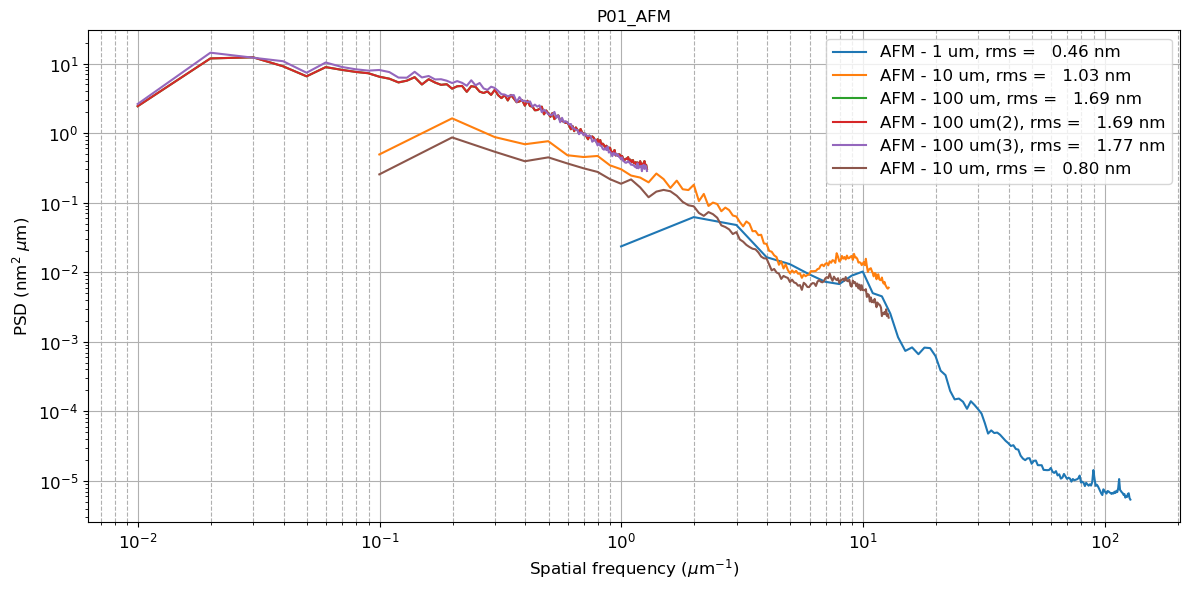

In [15]:
# PLOT ALL PSDS IN DATADIC
plt.close('all')

plot_all_psds(datadic,outfolder)

In [16]:
a = [os.path.basename(os.path.dirname(d[-1]))
     for d in [datadic[name][0] for name in datadic.keys()]]
b = datadic.keys()
print('keys - name')
for aa,bb in zip(a,b):
    print(bb,' - ',aa)

keys - name
P01_AFM  -  P01


## Merging of PSDs

All PSDs referred to same samples are merged by binned average over selected interval. Each PSD, coresponding to a group of data from a value in `datadic` and to a related set of intervals, is stored in a dictionary `tdic = {label:(f,p)}`.

### Inizialization

In [17]:
# outfolder = r'G:\My Drive\progetti\c_overcoating\esperimenti\results\20210227_trim_psds'
# outfolder = os.path.join(outdir,'psds','trim_psds')
os.makedirs(outfolder,exist_ok=True)

xrange = [6e-2,2e2] #[5e-4,5e2]
yrange = [5e-5,15] #[5e-4,1.5e6]
tdic={}
plt.close('all')

In [18]:
outfolder

'results\\P01'

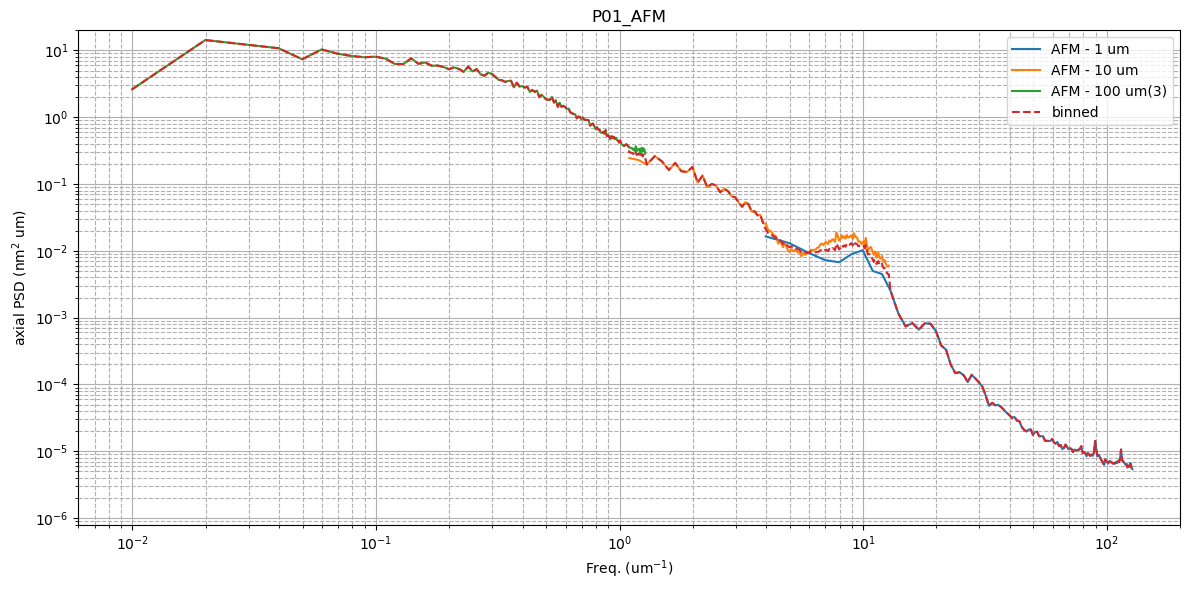

In [19]:
name = 'P01_AFM'   # select the result in the PSD dictionary
ranges = [[3,None], [1,None],None,
          None, [None,None],None]
#ranges = [[None,None], [None,None],[None,None],
#          [None,None], [None,None],[None,None]]

xrange = [6e-3,2e2] #[5e-4,5e2]
yrange = [8e-7,20] #[5e-4,1.5e6]

tdic[name] = trim_psds_group(ranges,*datadic[name],xrange=xrange,yrange=yrange,
                    outname=os.path.join(outfolder,name))

## Rebinning at low level

In [20]:
from pyProfile.profile import crop_profile

[103.59375    104.58984375 105.5859375  106.58203125 107.578125
 108.57421875 109.5703125  110.56640625 111.5625     112.55859375
 113.5546875  114.55078125 115.546875   116.54296875 117.5390625
 118.53515625 119.53125    120.52734375 121.5234375  122.51953125
 123.515625   124.51171875 125.5078125  126.50390625 127.5
   1.09570312   1.1953125    1.29492188   1.39453125   1.49414062]


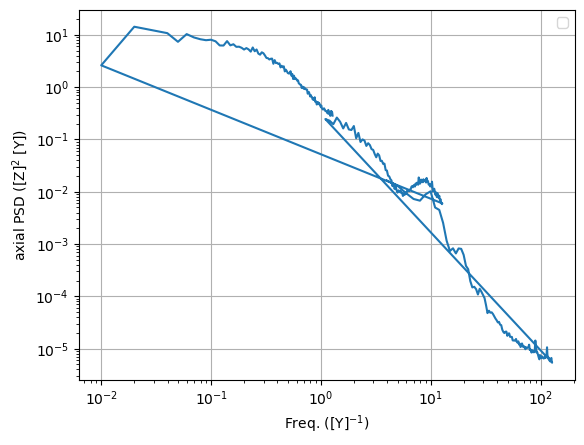

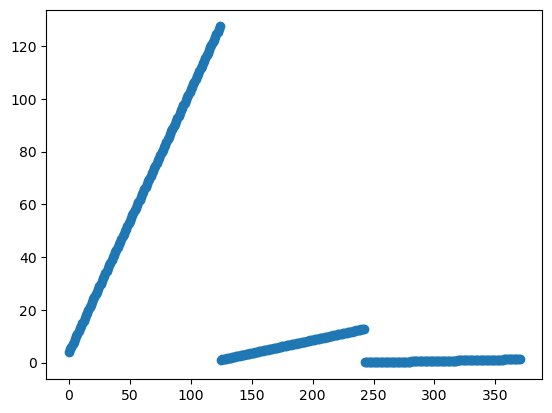

In [21]:
# tdic contains merged psd
plot_psd(*tdic[name])
plt.figure()
plt.plot(tdic[name][0],'o')
print(tdic[name][0][100:130])

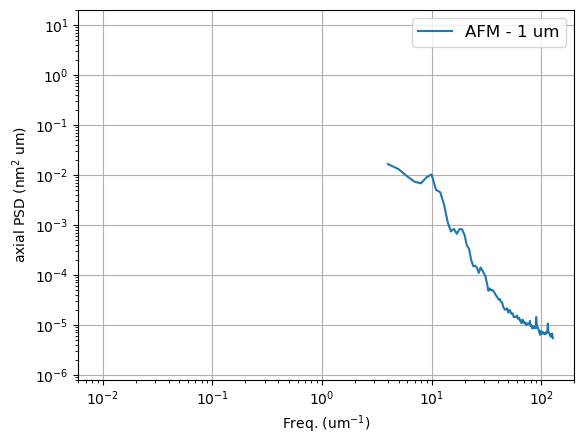

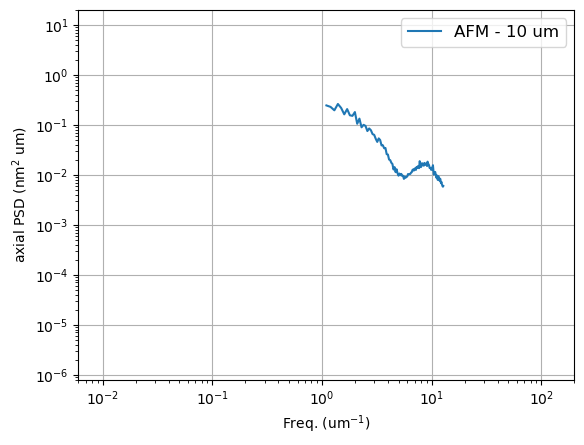

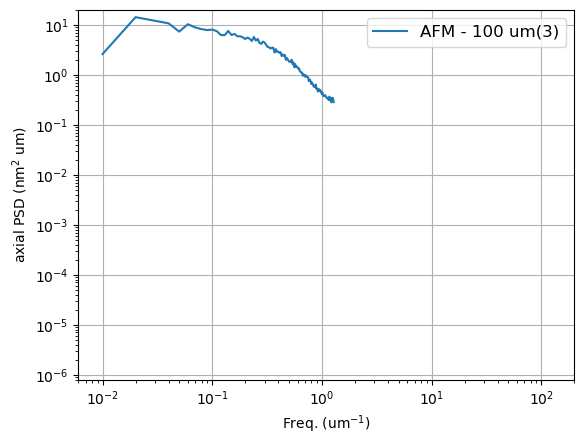

In [30]:
xtot,ytot,bins,xvals,yvals = [] , [], [], [], []
datafiles,labels = datadic[name]

for ran,fn,lab in zip(ranges,datafiles,labels):
    if ran is not None:
        #print(d)
        x,y = np.genfromtxt(fn_add_subfix(fn,'_psd','.dat'),unpack=True,skip_header=1)
        if x[0] == 0:
            x=x[1:]
            y=y[1:]
        xx,yy = crop_profile(x,y,ran)
        plt.figure()
        plot_psd(xx,yy,label=lab,units=['um','um','nm'])
        xtot.append(xx)
        ytot.append(yy)
    plt.legend( prop={'size': 12},loc = 1) #bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(xrange)
    plt.ylim(yrange)


In [31]:
[xx[:6] for xx in xtot]

[array([3.984375  , 4.98046875, 5.9765625 , 6.97265625, 7.96875   ,
        8.96484375]),
 array([1.09570312, 1.1953125 , 1.29492188, 1.39453125, 1.49414062,
        1.59375   ]),
 array([0.00996094, 0.01992187, 0.02988281, 0.03984375, 0.04980469,
        0.05976562])]

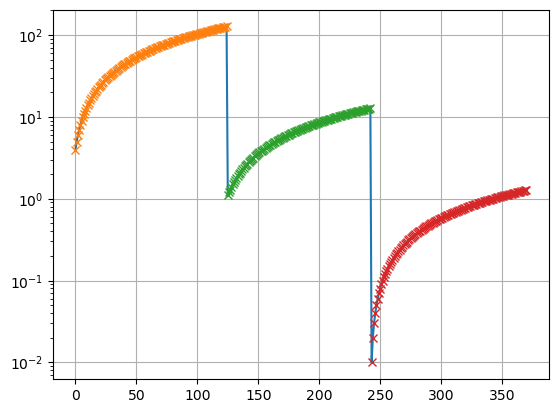

In [32]:
plt.plot(np.hstack(xtot))
plt.yscale("log")
n = 0 
for xx in xtot:
    x_ = np.arange(n, n+len(xx))
    n = n + len(xx)
    plt.plot(x_,xx,'x')

plt.grid()    

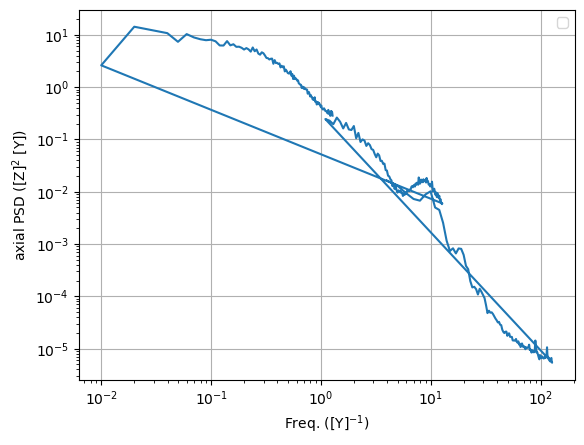

In [33]:
xtot=np.hstack(xtot)
ytot=np.hstack(ytot)
        
plt.figure()
plot_psd(xtot,ytot)

In [34]:
tdic.keys()

dict_keys(['P01_AFM'])